In [251]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as skl
import statsmodels
import statsmodels.api as sm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

print 'numpy = %s' % np.__version__
print 'pandas = %s' % pd.__version__
print 'scipy = %s' % sp.__version__
print 'scikit-earn = %s' % skl.__version__
print 'statsmodels = %s' % statsmodels.__version__

print 'seaborn = %s' % sns.__version__
print 'matplotlib = %s' % mpl.__version__

from scipy.stats import mannwhitneyu, ttest_ind, spearmanr
from scipy.stats.mstats import kruskalwallis

sns.set_style('whitegrid')

%matplotlib inline

numpy = 1.10.2
pandas = 0.22.0
scipy = 1.0.0
scikit-earn = 0.19.1
statsmodels = 0.8.0
seaborn = 0.8.0
matplotlib = 2.1.1


In [252]:
class taxonomy(object):
    
    def __init__(self,name):
        self.taxonomy = name
    
    def breakdown(self):
        taxa      = self.taxonomy; 
        taxa_dict = dict([ii.split('__') for ii in taxa.split(';')])
        return taxa_dict
    
    def dictionary(self):
        record = self.breakdown();
        for k,v in record.iteritems():
            record[k]=[v]
        return record

In [253]:
def microbeAbbreviateSuccinct(fullTaxonomy):

    levels = ['p','c','o','f','g','s'];
    descrp = {'p':'phylum','c':'class','o':'order',
              'f':'family','g':'genus','s':'species'}
    
    # if taxonomy includes an OTU ID
    if len(fullTaxonomy.split(';'))==8:
        
        # split into dictionary
        taxa_dict = taxonomy(fullTaxonomy).dictionary()
        
        # if both genus and species are known 
        if (len(taxa_dict['g'][0])>1) and (len(taxa_dict['s'][0])>1):
            taxa_abrv = ' '.join(taxa_dict['g']+taxa_dict['s']+["("+taxa_dict['otu'][0]+")"])
        else:
            # find the lowest known taxa level
            for l in levels[::-1]:
                if len(taxa_dict[l][0])>1:
                    break
            
            # find the highest unknown taxa level (i.e. next in line)
            unknown = (np.where([l==ii for ii in levels])[0]+1)[0]
            unknown = levels[unknown]
            unknown = descrp[unknown]

            # write out the abbreviation
            taxa_abrv = 'unclassified '+l+'__'+taxa_dict[l][0]
            
            # if otu id exists, append it
            if len(taxa_dict['otu'][0])>1:
                taxa_abrv += ' ('
                taxa_abrv += taxa_dict['otu'][0]
                taxa_abrv += ')' 
    
    # if it is a clade and not a unique OTU
    else:

        # split into dictionary
        taxa_dict = taxonomy(fullTaxonomy).dictionary()
        
        # if both genus and species are known 
        if ('s' in taxa_dict.keys()) and ('g' in taxa_dict.keys()) and (len(taxa_dict['g'][0])>1) and (len(taxa_dict['s'][0])>1):
                taxa_abrv = ' '.join(taxa_dict['g']+taxa_dict['s'])
                
        else:
            # what are the taxonomic levels?
            temp_levels = [levels[jj] for jj in range(0,np.where(['f' in ii for ii in levels])[0]+1)]
            
            # find the lowest known taxa level
            for l in temp_levels[::-1]:
                if len(taxa_dict[l][0])>1:
                    break
            
            # find the highest unknown taxa level (i.e. next in line)
            unknown = (np.where([l==ii for ii in temp_levels])[0])[0]
            unknown = levels[unknown]
            unknown = descrp[unknown]

            # write out the abbreviation
            taxa_abrv = l+'__'+taxa_dict[l][0]+" ("+unknown+")"

    return taxa_abrv

## Overview

**Use Mann-Whitney U-test for categorical variables and Spearman's rank correlation coefficient for continuous variables**

**Import OTU table**

In [254]:
biom = pd.read_csv('../generate_data/input_data/suscpetibility/otus.ygbr.day.2.txt',sep='\t',header=0,index_col=0)
biom = biom.T[biom.apply(np.sum)>0].T
print biom.shape
biom.head()

(76, 4181)


,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__;otu__1050608,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__;otu__130468,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__;otu__188753,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;otu__4467992,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;otu__530206,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__;otu__1081058,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira;s__;otu__4362724,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__flavefaciens;otu__301064,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea;s__;otu__183855,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium;s__acnes;otu__925397,...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea;s__;otu__3680006,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus;s__;otu__4315660,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__;otu__178184,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;otu__178148,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__;otu__178146,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__;otu__185312,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__prausnitzii;otu__196902,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__;otu__4438999,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__;otu__266061,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__;otu__181171
#SampleID,,,,,,,,,,,,,,,,,,,,,
SMIC.003.01.Day.02,0.012351,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SMIC.004.01.Day.02,0.000369,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SMIC.005.01.Day.02,0.000043,0.0,0.000022,0.0,0.0,0.000000,0.000022,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SMIC.006.01.Day.02,0.000065,0.0,0.000000,0.0,0.0,0.000065,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SMIC.006.02.Day.02,0.000031,0.0,0.000220,0.0,0.0,0.000000,0.000189,0.000063,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Import and modify meta-data**

In [255]:
clinical = pd.read_csv('../generate_data/input_data/suscpetibility/clinical.ygbr.day.2.txt',sep='\t',header=0,index_col=0)
clinical = clinical.loc[:,["ageyrs"]]

# binarize age 
clinical.loc[:,'ageyrs'] = clinical.ageyrs.apply(lambda x: [1 if x<=10 else 0][0])

print clinical.shape
clinical.head()

(76, 1)


,ageyrs
#SampleID,
SMIC.003.01.Day.02,0
SMIC.004.01.Day.02,0
SMIC.005.01.Day.02,0
SMIC.006.01.Day.02,0
SMIC.006.02.Day.02,0


In [256]:
outcomes = pd.read_csv('../generate_data/input_data/suscpetibility/outcomes.ygbr.day.2.txt',sep='\t',header=0,index_col=0)
clinical = clinical.join(outcomes,how='inner')
print clinical.shape
clinical.head()

(76, 2)


,ageyrs,color
#SampleID,,
SMIC.003.01.Day.02,0,1.0
SMIC.004.01.Day.02,0,0.0
SMIC.005.01.Day.02,0,1.0
SMIC.006.01.Day.02,0,0.0
SMIC.006.02.Day.02,0,0.0


### Categorical variable testing on all predictive gut OTUs (top 100)

In [259]:
features = pd.read_csv('../generate_data/output_data/S100_cv0_59024160/features.txt',sep='\t',header=0,index_col=0)
features = features.sort_index()
features = features.loc[range(1,101),:]
print features.shape
features.head()

(100, 1)


,Feature
Rank,
1,k__Bacteria;p__Actinobacteria;c__Actinobacteri...
2,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
3,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
4,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
5,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...


In [261]:
g_0 = clinical[clinical.ageyrs==0].index
g_1 = clinical[clinical.ageyrs==1].index

g_0 = np.log10(biom.loc[g_0,:]+1e-6);
g_1 = np.log10(biom.loc[g_1,:]+1e-6);

pvalues = [mannwhitneyu(g_0.loc[:,otu].values,g_1.loc[:,otu].values).pvalue for otu in features.values]

corrpvalues =  fdrcorrection0(pvalues,alpha=(.05),method='indep')

print '\trejected:',np.sum(corrpvalues[0])


	rejected: 2


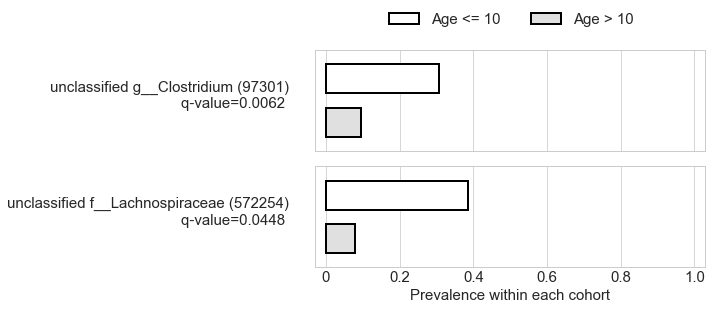

In [262]:
import seaborn as sns
sns.set_style('whitegrid')

hits = np.where([ii<0.05 for ii in corrpvalues[1]])[0]; 

fig,axes = plt.subplots(2,1,figsize=[7,2*len(hits)],sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.15,wspace=0.05)

for cnt,hit in enumerate(hits):
    
    ax = axes[cnt]
    
    otu_vs_age = pd.DataFrame(biom.loc[:,features.iloc[hit].values]).join(clinical.ageyrs)
    otu_vs_age.columns = ['otu','ageyrs'];

    # breakdown of otu presence by age
    present_ = otu_vs_age[otu_vs_age.otu>0].ageyrs.value_counts().values; 
    
    # breakdown of cohort by age
    age_ = otu_vs_age.ageyrs.value_counts().values; 
    
    # horizontal bar plots y-position
    bar_x = [float(nn)/dd for nn,dd in zip(present_,age_)]; 
    
    # horizontal bar plots
    ax.barh([0.8],bar_x[1],height=0.4,color=['#FFFFFF'],edgecolor='black',lw=2,label='Age <= 10')
    ax.barh([0.2],bar_x[0],height=0.4,color=['#E0E0E0'],edgecolor='black',lw=2,label='Age > 10')

    # set window limits
    ax.set_ylim([-0.2,1.2]); 
    ax.set_xlim([-0.03,1.03]);

    # add label on left
    ylabel_  = microbeAbbreviateSuccinct(features.iloc[hit].values[0])
    ylabel_ += '\nq-value=%0.4f '% corrpvalues[1][hit];
    
    # no ticks and labels on left side
    plt.setp(ax,yticks=[],yticklabels=[])

    # instead add OTU ID label and q-value
    ax.text(-0.1,0.4,ylabel_,fontsize=15,rotation=0,ha='right')

    # add legend 
    # add xticks on top
    if cnt==0:
        ax.legend(bbox_to_anchor=(0.85,1.5),ncol=2,fontsize=15)
        ax.xaxis.tick_top()
        [ii.set(fontsize=15,fontweight='normal') for ii in ax.get_xticklabels()+ax.get_yticklabels()]
        plt.setp(ax,xticks=[0,0.2,0.4,0.6,0.8,1.0],xticklabels=[0,0.2,0.4,0.6,0.8,1.0])
 
    # xlabel
    if cnt==1:
        ax.set_xlabel('Prevalence within each cohort',fontsize=15)
 
    # label size
    [ii.set(fontsize=15) for ii in ax.get_xticklabels()+ax.get_yticklabels()]

## Use OTU Clusters as response variables

### what are the clusters and their abundances?

In [263]:
otu_cluster_map = pd.read_csv('../generate_clusters/tax_thresh_0.9_cluster_membership.txt',sep='\t',header=None,index_col=0)
otu_cluster_map.columns=['cluster']
otu_cluster_map.index.name='OTU_id'
otu_cluster_map.head()

,cluster
OTU_id,
14279,2
15806,19
64384,11
69664,20
76393,38


In [264]:
cluster_abundances = pd.read_csv('../generate_clusters/tax_thresh_0.9_cluster_abundances.txt',sep='\t',header=0,index_col=0)
print cluster_abundances.shape
cluster_abundances.head()

(76, 43)


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
SMIC.036.01.Day.02,0.000161,0.000602,0.0,0.000000,0.000000,0.000120,0.0,0.0,0.000201,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000482,0.000040,0.000000,0.00004,0.000442
SMIC.029.01.Day.02,0.000000,0.000293,0.0,0.000176,0.000235,0.000088,0.0,0.0,0.000059,0.002817,...,0.000000,0.0,0.0,0.000059,0.0,0.002025,0.000147,0.000000,0.00000,0.000734
SMIC.021.03.Day.02,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.001057,0.000000,0.00000,0.000000
SMIC.007.01.Day.02,0.000221,0.000599,0.0,0.000441,0.000000,0.000063,0.0,0.0,0.000788,0.000630,...,0.000095,0.0,0.0,0.000000,0.0,0.015064,0.000441,0.000032,0.00000,0.000599
SMIC.018.01.Day.02,0.000027,0.000000,0.0,0.001091,0.000000,0.000053,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000053


### which OTUs are in each cluster?

In [265]:
clusters_ = {}

for index, row in clusters_fm.iterrows():
    
    if clusters_.has_key(row['cluster']):
        clusters_[row['cluster']].append(index)
    else:
        clusters_[row['cluster']] = [index]
        
clusters_

{0: [176726, 189760, 194557, 194733, 198422, 266274, 352747],
 1: [173917, 178420, 299302, 333042, 581021, 4307092, 4315782],
 2: [14279, 97301, 312509, 4331782],
 3: [545299, 4437359],
 4: [851824],
 5: [264552, 2157225],
 6: [786708],
 7: [190490],
 8: [288651],
 9: [4388068],
 10: [4334844],
 11: [64384],
 12: [338950],
 13: [194727],
 14: [1013285],
 15: [738351],
 16: [4079463],
 17: [199054],
 18: [3318103],
 19: [15806, 128390, 176077, 328617, 329693, 4396292],
 20: [69664, 180572, 2714942, 4326870, 4375860, 4404577, 4449458],
 21: [182383, 199430, 291266, 505541, 557974, 4368484],
 22: [137183, 190991, 282360, 292041, 1028283],
 23: [134726, 3829957],
 24: [198183],
 25: [180825, 190980, 227285, 366161, 2341726, 3384047, 4383922],
 26: [189610],
 27: [4446902],
 28: [91962, 179583, 196322, 4310223],
 29: [292921],
 30: [4329132],
 31: [3236435],
 32: [194824, 299837, 572254, 782953, 4301141],
 33: [181422],
 34: [196724],
 35: [593422],
 36: [4376230],
 37: [340219],
 38: [7639

In [266]:
g_0 = clinical[clinical.ageyrs==0].index
g_1 = clinical[clinical.ageyrs==1].index

g_0 = np.log10(cluster_abundances.loc[g_0,:]+1e-6);
g_1 = np.log10(cluster_abundances.loc[g_1,:]+1e-6);

pvalues = [mannwhitneyu(g_0.loc[:,cluster].values,g_1.loc[:,cluster].values).pvalue for cluster in cluster_abundances.keys()]

corrpvalues =  fdrcorrection0(pvalues,alpha=(.05),method='indep')

print '\trejected:',np.sum(corrpvalues[0])


	rejected: 4


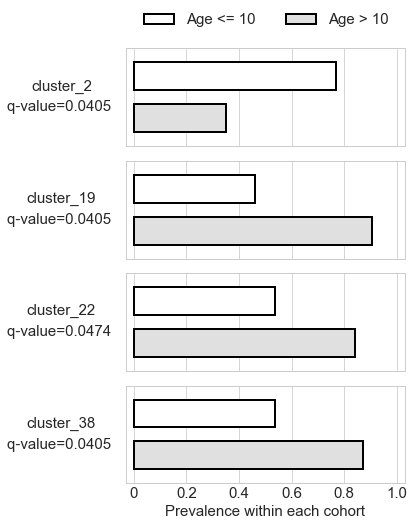

In [271]:
import seaborn as sns
sns.set_style('whitegrid')

hits = np.where([ii<0.05 for ii in corrpvalues[1]])[0];

fig,axes = plt.subplots(4,1,figsize=[5,2*len(hits)],sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.15,wspace=0.05)

for cnt,hit in enumerate(hits):
    
    ax = axes[cnt]
    
    otu_vs_age = pd.DataFrame(cluster_abundances.loc[:,str(hit)]).join(clinical.ageyrs)
    otu_vs_age.columns = ['otu','ageyrs'];

    # breakdown of otu presence by age
    present_ = otu_vs_age[otu_vs_age.otu>0].ageyrs.value_counts().values; 
    
    # breakdown of cohort by age
    age_ = otu_vs_age.ageyrs.value_counts().values; 
    
    # horizontal bar plots y-position
    bar_x = [float(nn)/dd for nn,dd in zip(present_,age_)]; 
    
    # horizontal bar plots
    ax.barh([0.8],bar_x[1],height=0.4,color=['#FFFFFF'],edgecolor='black',lw=2,label='Age <= 10')
    ax.barh([0.2],bar_x[0],height=0.4,color=['#E0E0E0'],edgecolor='black',lw=2,label='Age > 10')

    # set window limits
    ax.set_ylim([-0.2,1.2]); 
    ax.set_xlim([-0.03,1.03]);

    # add label on left
    ylabel_2 = 'cluster_%s' %  str(hit)
    ylabel_1 = '\nq-value=%0.4f '% corrpvalues[1][hit];
    
    # no ticks and labels on left side
    plt.setp(ax,yticks=[],yticklabels=[])

    # instead add OTU ID label and q-value
    ax.text(-0.275,0.60,ylabel_2,fontsize=15,rotation=0,ha='center')
    ax.text(-0.275,0.30,ylabel_1,fontsize=15,rotation=0,ha='center')

    # add legend 
    # add xticks on top
    if cnt==0:
        ax.legend(bbox_to_anchor=(0.99,1.5),ncol=2,fontsize=15)
        ax.xaxis.tick_top()
        [ii.set(fontsize=15,fontweight='normal') for ii in ax.get_xticklabels()+ax.get_yticklabels()]
        plt.setp(ax,xticks=[0,0.2,0.4,0.6,0.8,1.0],xticklabels=[0,0.2,0.4,0.6,0.8,1.0])
 
    # xlabel
    if cnt==3:
        ax.set_xlabel('Prevalence within each cohort',fontsize=15)
 
    # label size
    [ii.set(fontsize=15) for ii in ax.get_xticklabels()+ax.get_yticklabels()]